<a href="https://colab.research.google.com/github/kevsatt/image_segmentation_fastai/blob/master/image_segmentation_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create a new folder on Google Drive named data.

The content of these folders is 500 images in black of white of eyes.

The masks folder is 500 masks segmenting the iris, sclera, and pupil.

Image:

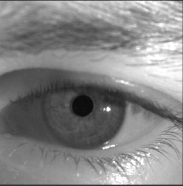

Mask:

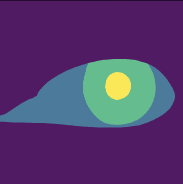

Your folder hiearchy in Google Drive should look like this:

/content/drive/My Drive/data/images/imgs_small

/content/drive/My Drive/data/masks/masks_small

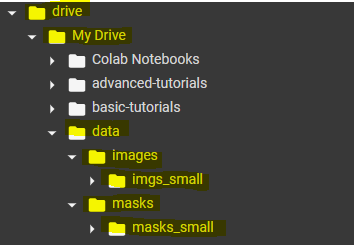

In [0]:
%%capture
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Import packages we'll need. Chose to use FastAI. Wanted to decrease development time on model so that time could be spent deploying it later.

Muting some of the annoying warnings and making sure that plots will show up in the notebook.

In [0]:
from fastai.vision import *
from fastai.utils.mem import *
from fastai.callbacks.hooks import *
import pandas as pd
import glob
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

get_ipython().__class__.__name__ = "ZMQInteractiveShell"
get_ipython().__class__.__name__

'ZMQInteractiveShell'

Getting our data and a couple of sanity checks to make sure we're referencing the right path.

In [0]:
path_images = Path("/content/drive/My Drive/data")
path_lbl = path_images
fnames = glob.glob('/content/drive/My Drive/data/images/imgs_small/*.jpg')
lbl_names = glob.glob('/content/drive/My Drive/data/masks/masks_small/*.png')
fnames[1]

'/content/drive/My Drive/data/images/imgs_small/set_10_frame_29.jpg'

In [0]:
lbl_names[20]

'/content/drive/My Drive/data/masks/masks_small/set_12_frame_157.png'

Two functions we will need to run our model. 

The first function, get_y_fn() will map images to masks.

The second function will be used as our accuracy measurement. We are making sure that we are only comparing the predicted mask to the ground truth mask on pixels that are not the "void_code" which is the background. In this case the background is the area outside of the eye itself.

In [0]:
def get_y_fn(x):
    x = Path(x)
    y = r'/content/drive/My Drive/data/masks/masks_small' + '/' + f'{x.stem}.png'
    return y

def acc_image_seg(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

Let's check how much GPU memory we have. 
We'll change our batch size according to this. 

To use Google Colab's free GPU, please go to "Runtime" -> "Change Runtime Type" -> Change "Hardware Accelerator" to GPU.

In [0]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200:
    bs = 8
else:
    bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


Converting mask and dividing the size in half for training.

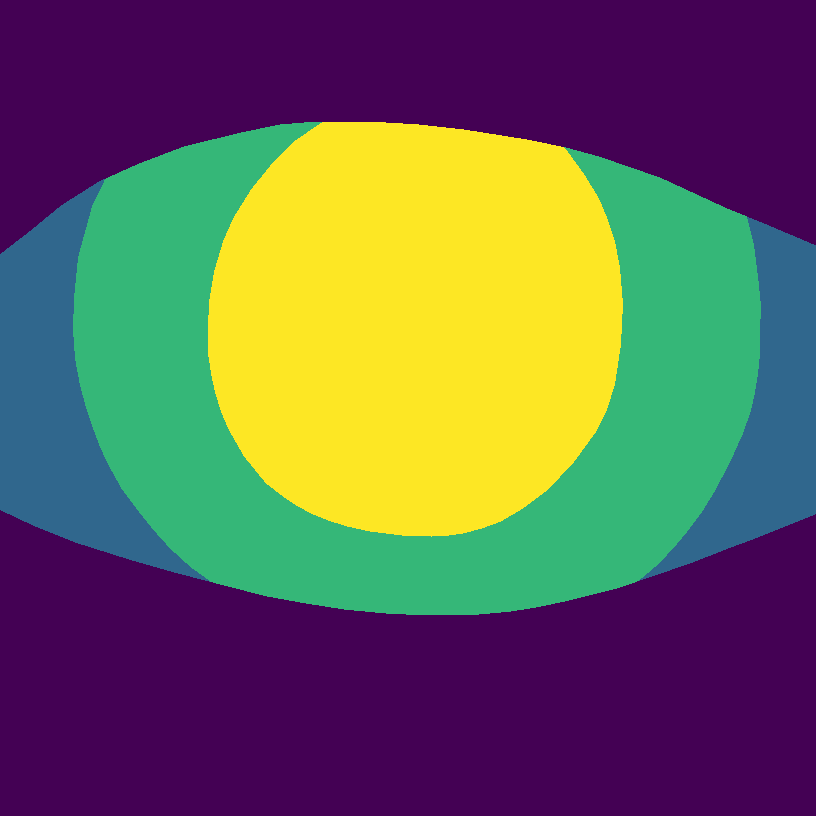

In [0]:
img_f = fnames[3]

mask = open_mask(get_y_fn(img_f), convert_mode='L')

src_size = np.array(mask.shape[1:])

filter_func = lambda x: str(x) in fnames

size = src_size // 2

#another sanity check
mask

Instantiate data classes to pass to FastAi's unet_learner object. 

In [0]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, convert_mode='L')


class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

codes = ['Background', 'Sclera', 'Iris', 'Pupil']

src = (SegItemListCustom.from_folder(path_images)
       .filter_by_func(filter_func)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

Enumerating our classes to predict and naming our void_code. Instantiating unet_learner object.

In [0]:
name2id = {v: k for k, v in enumerate(codes)}
void_code = name2id['Background']
learn = unet_learner(data, models.resnet34, metrics=acc_image_seg, wd=1e-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 70.4MB/s]


Find the right learning rate and apply it to our model training.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-05
Min loss divided by 10: 2.29E-03


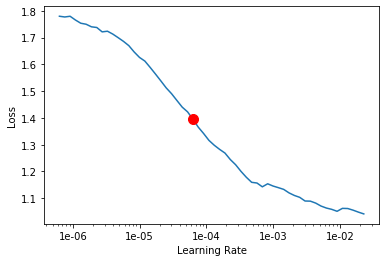

In [0]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

Train our model for 10 epochs and save the weights to 'unet_eye_1'.

If you want to predict without retraining model you can load the weights using the commented out command below.

In [0]:
# training 
learn.fit_one_cycle(20, min_grad_lr, pct_start=0.9)
learn.save('unet_eye_seg')
learn.export('unet_eye_seg_model')

# loading model and predicting
# learn.load('unet_eye_seg')

epoch,train_loss,valid_loss,acc_image_seg,time
0,1.145608,0.924540,0.200037,03:00
1,0.816677,0.531407,0.524402,01:30
2,0.583082,0.382655,0.709182,01:30
3,0.429816,0.287889,0.740678,01:30
4,0.331860,0.217068,0.858376,01:30
5,0.272737,0.176857,0.881098,01:30
6,0.238983,0.157010,0.909236,01:30
7,0.196963,0.179068,0.924244,01:30
8,0.166731,0.138822,0.920225,01:30
9,0.147218,0.114384,0.934280,01:29


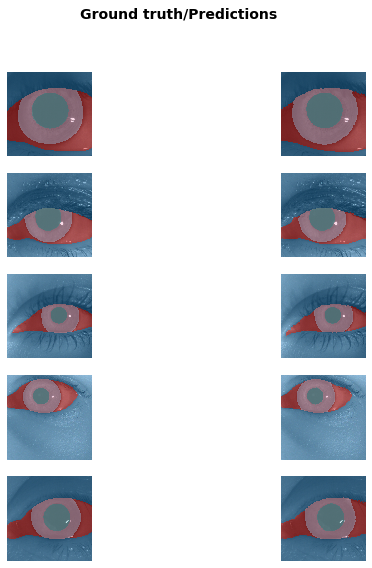

In [0]:
learn.show_results(rows=5, figsize=(9, 9))